In [14]:
from recsim import document
from recsim import user
from recsim.choice_model import MultinomialLogitChoiceModel
from recsim.simulator import environment
from recsim.simulator import recsim_gym

import numpy as np
from gym import spaces
import matplotlib.pyplot as plt
from scipy import stats

### Documents

In [15]:
class LTSDocument(document.AbstractDocument):
  def __init__(self, doc_id, kaleness):
    self.kaleness = kaleness
    # doc_id is an integer representing the unique ID of this document
    super(LTSDocument, self).__init__(doc_id)

  def create_observation(self):
    return np.array([self.kaleness])

  @staticmethod
  def observation_space():
    return spaces.Box(shape=(1,), dtype=np.float32, low=0.0, high=1.0)
  
  def __str__(self):
    return "Document {} with kaleness {}.".format(self._doc_id, self.kaleness)

In [16]:
class LTSDocumentSampler(document.AbstractDocumentSampler):
  def __init__(self, doc_ctor=LTSDocument, **kwargs):
    super(LTSDocumentSampler, self).__init__(doc_ctor, **kwargs)
    self._doc_count = 0

  def sample_document(self):
    doc_features = {}
    doc_features['doc_id'] = self._doc_count
    doc_features['kaleness'] = self._rng.random_sample()
    self._doc_count += 1
    return self._doc_ctor(**doc_features)

In [17]:
sampler = LTSDocumentSampler()
for i in range(5): print(sampler.sample_document())
d = sampler.sample_document()
print("Documents have observation space:", d.observation_space(), "\n"
      "An example realization is: ", d.create_observation())
     

Document 0 with kaleness 0.5488135039273248.
Document 1 with kaleness 0.7151893663724195.
Document 2 with kaleness 0.6027633760716439.
Document 3 with kaleness 0.5448831829968969.
Document 4 with kaleness 0.4236547993389047.
Documents have observation space: Box(0.0, 1.0, (1,), float32) 
An example realization is:  [0.64589411]


### Users

In [21]:
class LTSUserState(user.AbstractUserState):
  def __init__(self, memory_discount, sensitivity, innovation_stddev,
              choc_mean, choc_stddev, kale_mean, kale_stddev,
              net_kaleness_exposure, time_budget, observation_noise_stddev=0.1
            ):
    ## Transition model parameters
    ##############################
    self.memory_discount = memory_discount
    self.sensitivity = sensitivity
    self.innovation_stddev = innovation_stddev

    ## Engagement parameters
    self.choc_mean = choc_mean
    self.choc_stddev = choc_stddev
    self.kale_mean = kale_mean
    self.kale_stddev = kale_stddev

    ## State variables
    ##############################
    self.net_kaleness_exposure = net_kaleness_exposure
    self.satisfaction = 1 / (1 + np.exp(-sensitivity * net_kaleness_exposure))
    self.time_budget = time_budget

    # Noise
    self._observation_noise = observation_noise_stddev

  def create_observation(self):
    """User's state is not observable."""
    clip_low, clip_high = (-1.0 / (1.0 * self._observation_noise),
                            1.0 / (1.0 * self._observation_noise))
    noise = stats.truncnorm(
        clip_low, clip_high, loc=0.0, scale=self._observation_noise).rvs()
    noisy_sat = self.satisfaction + noise
    return np.array([noisy_sat,])

  @staticmethod
  def observation_space():
   return spaces.Box(shape=(1,), dtype=np.float32, low=-2.0, high=2.0)

  # scoring function for use in the choice model -- the user is more likely to
  # click on more chocolatey content.
  def score_document(self, doc_obs):
    return 1 - doc_obs

In [22]:
class LTSStaticUserSampler(user.AbstractUserSampler):
  _state_parameters = None

  def __init__(self,
               user_ctor=LTSUserState,
               memory_discount=0.9,
               sensitivity=0.01,
               innovation_stddev=0.05,
               choc_mean=5.0,
               choc_stddev=1.0,
               kale_mean=4.0,
               kale_stddev=1.0,
               time_budget=60,
               **kwargs):
    self._state_parameters = {'memory_discount': memory_discount,
                              'sensitivity': sensitivity,
                              'innovation_stddev': innovation_stddev,
                              'choc_mean': choc_mean,
                              'choc_stddev': choc_stddev,
                              'kale_mean': kale_mean,
                              'kale_stddev': kale_stddev,
                              'time_budget': time_budget
                             }
    super(LTSStaticUserSampler, self).__init__(user_ctor, **kwargs)

  def sample_user(self):
    starting_nke = ((self._rng.random_sample() - .5) *
                    (1 / (1.0 - self._state_parameters['memory_discount'])))
    self._state_parameters['net_kaleness_exposure'] = starting_nke
    return self._user_ctor(**self._state_parameters)

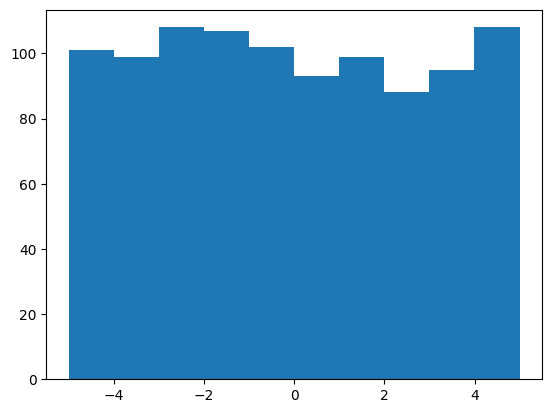

In [23]:
sampler = LTSStaticUserSampler()
starting_nke = []
for i in range(1000):
  sampled_user = sampler.sample_user()
  starting_nke.append(sampled_user.net_kaleness_exposure)
_ = plt.hist(starting_nke)     

### Response

In [24]:
class LTSResponse(user.AbstractResponse):
  # The maximum degree of engagement.
  MAX_ENGAGEMENT_MAGNITUDE = 100.0

  def __init__(self, clicked=False, engagement=0.0):
    self.clicked = clicked
    self.engagement = engagement

  def create_observation(self):
    return {'click': int(self.clicked), 'engagement': np.array(self.engagement)}

  @classmethod
  def response_space(cls):
    # `engagement` feature range is [0, MAX_ENGAGEMENT_MAGNITUDE]
    return spaces.Dict({
        'click':
            spaces.Discrete(2),
        'engagement':
            spaces.Box(
                low=0.0,
                high=cls.MAX_ENGAGEMENT_MAGNITUDE,
                shape=tuple(),
                dtype=np.float32)
    })
     

### User Model

In [37]:
class LTSUserModel(user.AbstractUserModel):
    def __init__(self,slate_size,seed=0):
        super(LTSUserModel,self).__init__(LTSResponse,LTSStaticUserSampler(LTSUserState,seed=seed), slate_size)
        self.choice_model = MultinomialLogitChoiceModel({})

    def simulate_response(self, slate_documents):
        # List of empty responses
        responses = [self._response_model_ctor() for _ in slate_documents]
        # Get click from of choice model.
        self.choice_model.score_documents(
            self._user_state, [doc.create_observation() for doc in slate_documents])
        scores = self.choice_model.scores
        selected_index = self.choice_model.choose_item()
        # Populate clicked item.
        self._generate_response(slate_documents[selected_index],
                                responses[selected_index])
        return responses

    def _generate_response(self, doc, response):
        response.clicked = True
        # linear interpolation between choc and kale.
        engagement_loc = (doc.kaleness * self._user_state.choc_mean
                            + (1 - doc.kaleness) * self._user_state.kale_mean)
        engagement_loc *= self._user_state.satisfaction
        engagement_scale = (doc.kaleness * self._user_state.choc_stddev
                            + ((1 - doc.kaleness)
                                * self._user_state.kale_stddev))
        log_engagement = np.random.normal(loc=engagement_loc,
                                            scale=engagement_scale)
        response.engagement = np.exp(log_engagement)

    def update_state(self, slate_documents, responses):
        for doc, response in zip(slate_documents, responses):
            if response.clicked:
                innovation = np.random.normal(scale=self._user_state.innovation_stddev)
                net_kaleness_exposure = (self._user_state.memory_discount
                                            * self._user_state.net_kaleness_exposure
                                            - 2.0 * (doc.kaleness - 0.5)
                                            + innovation
                                        )
                self._user_state.net_kaleness_exposure = net_kaleness_exposure
                satisfaction = 1 / (1.0 + np.exp(-self._user_state.sensitivity
                                                    * net_kaleness_exposure)
                                    )
                self._user_state.satisfaction = satisfaction
                self._user_state.time_budget -= 1
                return
    
    def is_terminal(self):
        """Returns a boolean indicating if the session is over."""
        return self._user_state.time_budget <= 0
       

In [38]:
slate_size = 3
num_candidates = 10
ltsenv = environment.Environment(
        LTSUserModel(slate_size),
        LTSDocumentSampler(),
        num_candidates,
        slate_size,
        resample_documents=True)

### Environment

In [39]:
#Reward Function like
def clicked_engagement_reward(responses):
  reward = 0.0
  for response in responses:
    if response.clicked:
      reward += response.engagement
  return reward

In [40]:
lts_gym_env = recsim_gym.RecSimGymEnv(ltsenv, clicked_engagement_reward)

In [41]:
observation_0 = lts_gym_env.reset()
print('Observation 0')
print('Available documents')
doc_strings = ['doc_id ' + key + " kaleness " + str(value) for key, value
               in observation_0['doc'].items()]
print('\n'.join(doc_strings))
print('Noisy user state observation')
print(observation_0['user'])
# Agent recommends the first three documents.
recommendation_slate_0 = [0, 1, 2]
observation_1, reward, done, _ = lts_gym_env.step(recommendation_slate_0)
print('Observation 1')
print('Available documents')
doc_strings = ['doc_id ' + key + " kaleness " + str(value) for key, value
               in observation_1['doc'].items()]
print('\n'.join(doc_strings))
rsp_strings = [str(response) for response in observation_1['response']]
print('User responses to documents in the slate')
print('\n'.join(rsp_strings))
print('Noisy user state observation')
print(observation_1['user'])

Observation 0
Available documents
doc_id 10 kaleness [0.79172504]
doc_id 11 kaleness [0.52889492]
doc_id 12 kaleness [0.56804456]
doc_id 13 kaleness [0.92559664]
doc_id 14 kaleness [0.07103606]
doc_id 15 kaleness [0.0871293]
doc_id 16 kaleness [0.0202184]
doc_id 17 kaleness [0.83261985]
doc_id 18 kaleness [0.77815675]
doc_id 19 kaleness [0.87001215]
Noisy user state observation
[0.55226738]
Observation 1
Available documents
doc_id 20 kaleness [0.97861834]
doc_id 21 kaleness [0.79915856]
doc_id 22 kaleness [0.46147936]
doc_id 23 kaleness [0.78052918]
doc_id 24 kaleness [0.11827443]
doc_id 25 kaleness [0.63992102]
doc_id 26 kaleness [0.14335329]
doc_id 27 kaleness [0.94466892]
doc_id 28 kaleness [0.52184832]
doc_id 29 kaleness [0.41466194]
User responses to documents in the slate
{'click': 0, 'engagement': array(0.)}
{'click': 1, 'engagement': array(6.76540017)}
{'click': 0, 'engagement': array(0.)}
Noisy user state observation
[0.62844271]
